# Makemore part 3

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [179]:
len(words)

32033

In [180]:
# build the vocab for characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [181]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [182]:
vocab_size

27

In [187]:
# MLP 
n_embed = 10 # dim of character embedding vectors
n_hidden = 200 # num of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
#b1 = torch.randn(n_hidden, generator=g) * 0.01  # bias gets cancelled during BN, hence we can ignore it
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in totol
for p in parameters:
    p.requires_grad = True

"""
We initialize the weights of W1 by 5/3 bcz that is for tanh part, and scale it to 1/root(fan_in) makes it roughly gaussian : maintains stable variance for activations during the forward pass
"""
pass

12097


In [188]:
hpreact.shape

torch.Size([100, 200])

In [189]:
# same optimization as last time
max_steps = 200000
batch_size = 100
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, WE CAN remove bias b1 also as BN makes bias as zero (becomes subtracted out later)
    # Batch Normaliation (normally placed after multiplication - Linear or conv layers)
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # can add epsilon also, centering to unit gaussian, then offseting and scaling with bngain and bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # We are finding these values so we can use it in inference 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # We are finding these values so we can use it in inference 
    # Non Linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss  = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    
    

"""
Problem 1. we are getting a super high nonsensical loss at initialization, ideal initial loss should be around 1/27 log whcih is 
-torch.tensor(1/27).log() whichb comes around 3.29 But we are getting a loss of 27.88 in initialization, thats because the initial parameters are having extreme values during initialization, try making logits closer to zero to get a better initializaiton loss

Things done to fix this
1. Make initial b2 bias as 0 as we dont need bias during the initialization
2. Reduce the size of W2 (multiply by 0.01 here) as it will make the values of logits smaller (logits - h @ W2 + b2)

Problem 2. There are too many(most) -1 and 1 values in hidden layer(h) HENCE When backprop of tanh (which is (1-t**2)*out_grad) we have 1 or -1, that makes the backpropagation zero which makes the vanishing gradient problem

Things done to fix this
1. We have to reduce the h value so its closer to zero, hence we reduce W1 and b1 by multiplying with 0.1 and 0.01

***Kaiming Init For tanh we add a factor od 5/3 * sqrt(n_embed*block_size), this is diff for diff activation functions. This makes the standard deviation 1 which is needed 

Batchnorm


Normally the order of a network is
Weight layer --> BatchNorm layer --> Non Linearity layer

"""

pass

      0/  200000: 3.3067
  10000/  200000: 2.2585
  20000/  200000: 2.0668
  30000/  200000: 2.2160
  40000/  200000: 2.0987
  50000/  200000: 2.2199
  60000/  200000: 2.1734
  70000/  200000: 1.9276
  80000/  200000: 2.1350
  90000/  200000: 2.1474
 100000/  200000: 1.8248
 110000/  200000: 1.8545
 120000/  200000: 2.0966
 130000/  200000: 1.9468
 140000/  200000: 2.2599
 150000/  200000: 2.1486
 160000/  200000: 1.9672
 170000/  200000: 1.9613
 180000/  200000: 1.9704
 190000/  200000: 2.0416


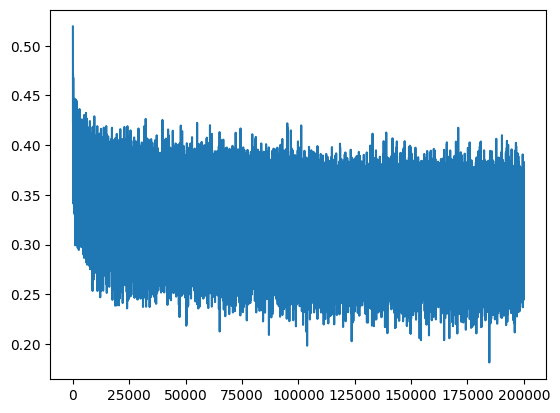

In [190]:
plt.plot(lossi);

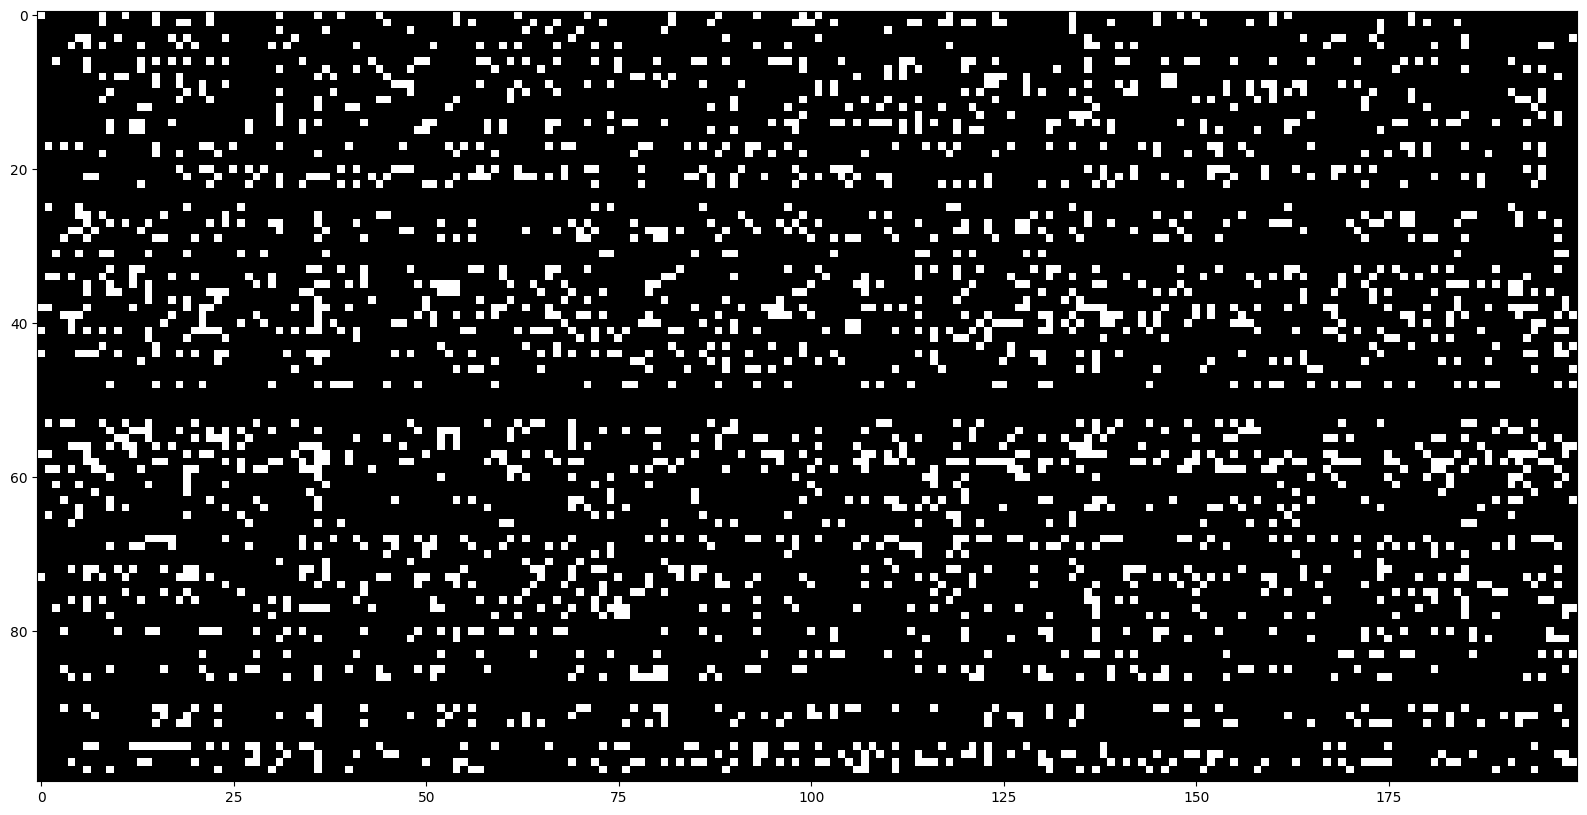

In [191]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # shape of h is (32, 200) White is true, black is false

In [195]:
probs.shape

torch.Size([1, 27])

In [161]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [192]:
# # calibrate batchnorm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
""" We replace all this with bnmean_running and bnstd_runn which we find during training, use that instead"""


' We replace all this with bnmean_running and bnstd_runn which we find during training, use that instead'

In [193]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # replaced with the found avg batchnorm val of during entire training, before it was post training (prev cell)
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0342161655426025
val 2.0925474166870117
test 2.091510057449341


In [164]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word
    

nbrellequethl.
shbrmylirelly.
sklassafjazcellfernsyha.
prqhif.
quaniftchmihviksleggpvy.
maddis.
quinths.
luvranvanbiylahellyssarisixfkyuspinslivesteppia.
gtrafhastly.
prasmingracsymantellsozswylljssia.
jafrendep.
sadlucoclom.
susolazkryndra.
pllmanransshernyxxnyvanbhdn.
bryndellyssvioslddgprissaldykkmciepazziyaanpe.
khsesustiffamdyevenhy.
qlyctorrowordubransskingty.
zaindzs.
matkellistiner.
sch.


# Converting it to a Linear Modular code

In [231]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training=True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calc the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)   # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)  #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # numbet of parameters in total
for p in parameters:
    p.requires_grad = True

47497


In [232]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2869


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.88%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.28%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.25%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

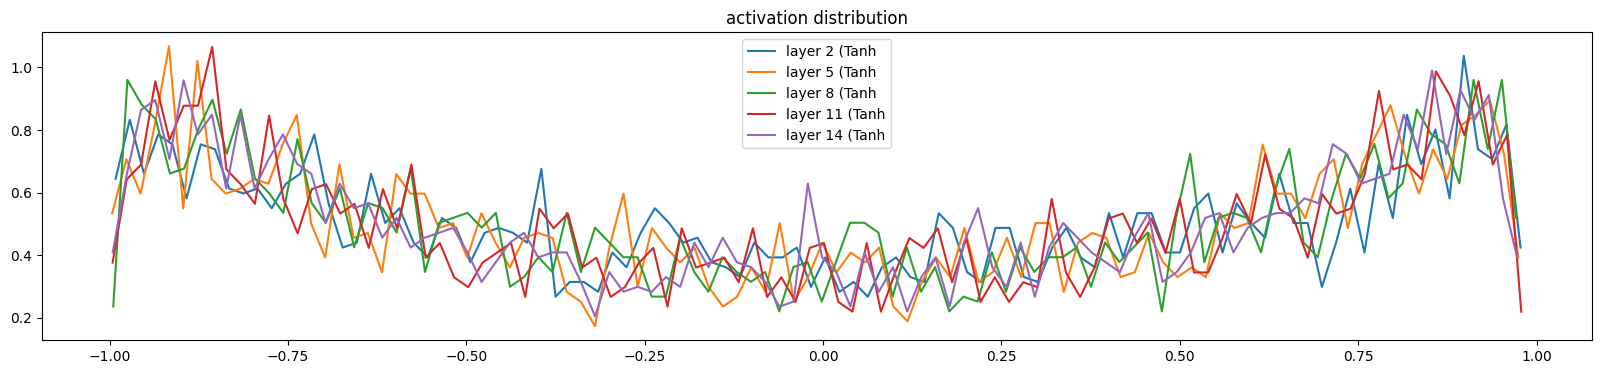

In [233]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.722006e-03
layer 5 (      Tanh): mean +0.000000, std 3.188131e-03
layer 8 (      Tanh): mean +0.000000, std 2.911042e-03
layer 11 (      Tanh): mean +0.000000, std 2.574726e-03
layer 14 (      Tanh): mean +0.000004, std 2.095988e-03


Text(0.5, 1.0, 'gradient distribution')

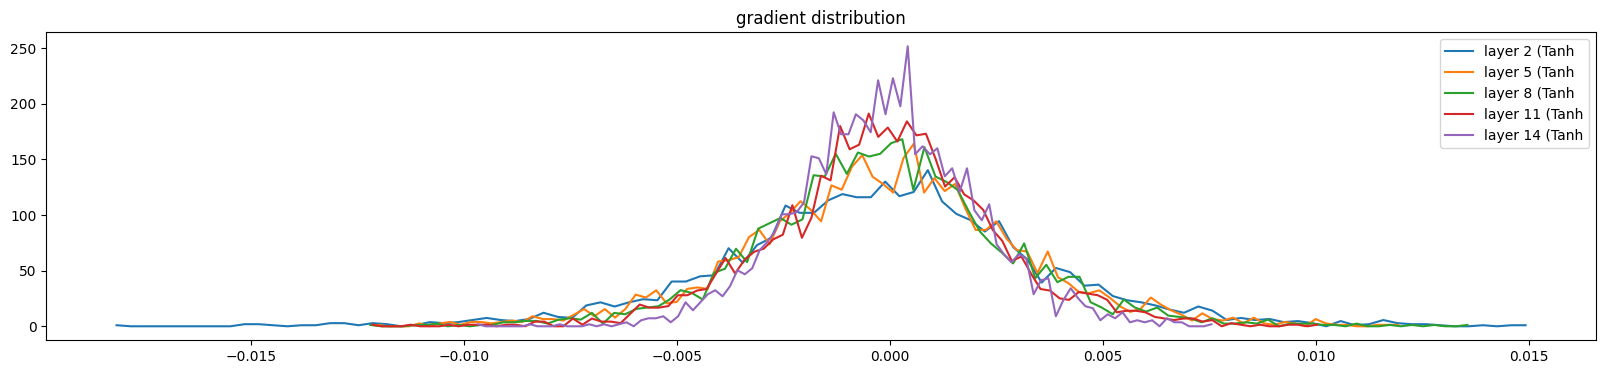

In [234]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.953359e-03 | grad:data ratio 9.941167e-03
weight  (30, 100) | mean -0.000060 | std 8.133629e-03 | grad:data ratio 2.598559e-02
weight (100, 100) | mean -0.000090 | std 6.771773e-03 | grad:data ratio 4.037309e-02
weight (100, 100) | mean -0.000030 | std 6.025952e-03 | grad:data ratio 3.566696e-02
weight (100, 100) | mean -0.000003 | std 5.615909e-03 | grad:data ratio 3.343026e-02
weight (100, 100) | mean +0.000004 | std 4.467471e-03 | grad:data ratio 2.662125e-02
weight  (100, 27) | mean -0.000000 | std 1.932996e-02 | grad:data ratio 3.041834e-01


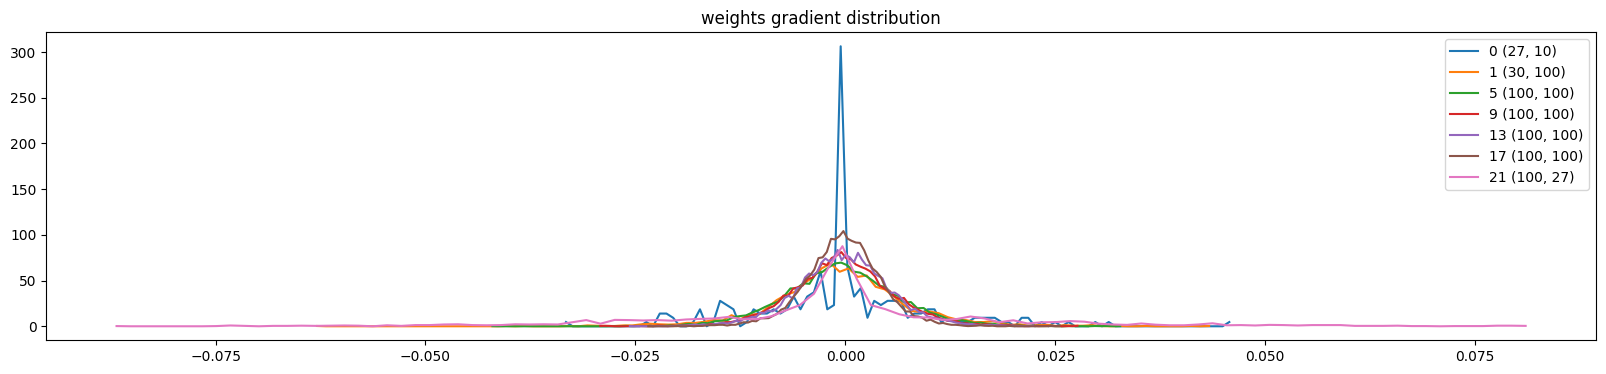

In [235]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

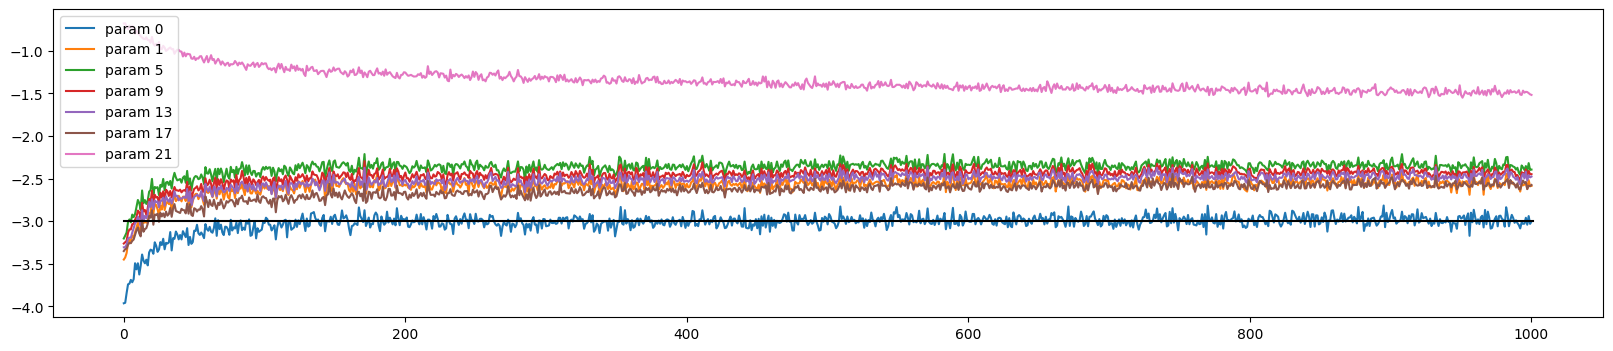

In [236]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [215]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.275756359100342
val 3.274867534637451


In [217]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

cvrpzhxqab.
hqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduxlhggphhbmgpoinfqbqjtzsrlivwa.
vvdbquwqjehogdjaryxixfkqeupiusdbwed.
ecxia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojqmwycjsfrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxah.
xqioloqbprbvbbda.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrnzazqnljydpk.
kvweskatimzamdtevl.
ky.
qdyctoorowooktbymomokibfcw.
zoinhzcs.
nu.
eoaignqqeroqci.
ipjzykbadyieluglc.
nwzyzdjokhnlhfzqsxmuadmtjhvtoyaplwuw.
xisxwrdfv.
zphtzbiuzzsrvgmknbfyntiysfgdglnmmj.
